In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

In [2]:
# Read in data
df = pd.read_csv('HCVData.csv') 

# Drop Patient ID column
df.drop(df.columns[0],axis=1,inplace=True)
print(df.head())
df1 = df.replace(['0s=suspect Blood Donor','1=Hepatitis','2=Fibrosis','3=Cirrhosis'],'1=Non-Blood Donor')
df2 = df1.replace(['0=Blood Donor','1=Non-Blood Donor'],[0,1])

        Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA  \
0  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0   
1  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0   
2  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0   
3  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0   
4  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0   

    GGT  PROT  
0  12.1  69.0  
1  15.6  76.5  
2  33.2  79.3  
3  33.8  75.7  
4  29.9  68.7  


In [3]:
# EDA
print(df2.shape)
pd.set_option('display.max_rows', None) 
print(df2.dtypes)
print(df2['Category'].value_counts())

(615, 13)
Category      int64
Age           int64
Sex          object
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
dtype: object
Category
0    533
1     82
Name: count, dtype: int64


In [4]:
# Check for missing values
perc_missing_per_ftr = df2.isnull().sum(axis=0)/df2.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df2[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df2.isnull().sum(axis=1)!=0)/df2.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
ALB     0.001626
ALP     0.029268
ALT     0.001626
CHOL    0.016260
PROT    0.001626
dtype: float64
data types of the features with missing values:
ALB     float64
ALP     float64
ALT     float64
CHOL    float64
PROT    float64
dtype: object
fraction of points with missing values: 0.04227642276422764


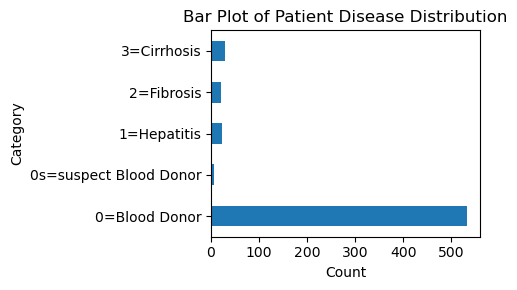

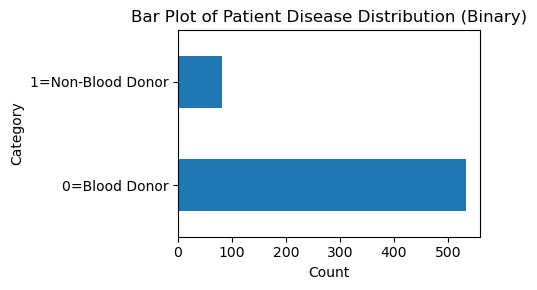

In [5]:
# Visualize Target Variable
correct_order = ['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis']
pd.value_counts(df['Category']).reindex(correct_order)
plt.figure(figsize=(5,3))
pd.value_counts(df['Category']).reindex(correct_order).plot.barh()
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Bar Plot of Patient Disease Distribution')
plt.tight_layout()
plt.show()
plt.figure(figsize=(5,3))
pd.value_counts(df1['Category']).plot.barh()
plt.ylabel('Category')
plt.xlabel('Count')
plt.title('Bar Plot of Patient Disease Distribution (Binary)')
plt.tight_layout()
plt.show()

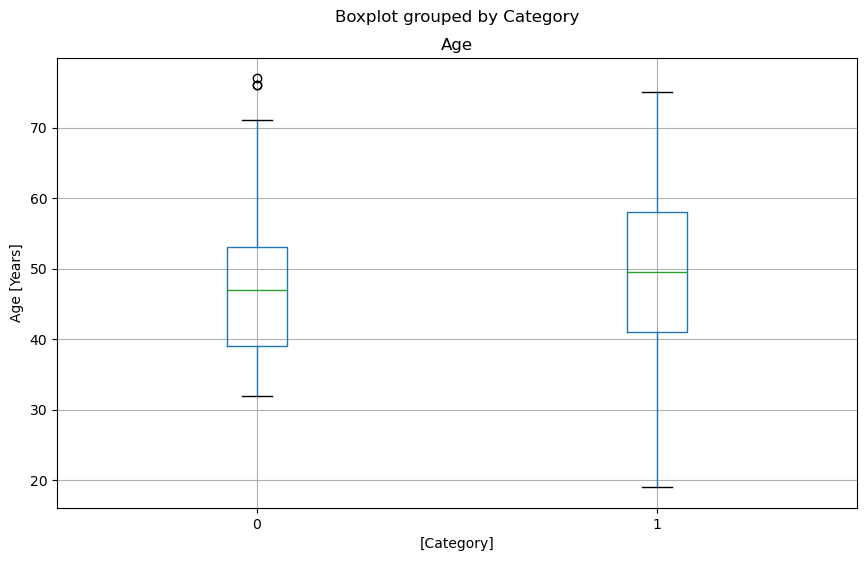

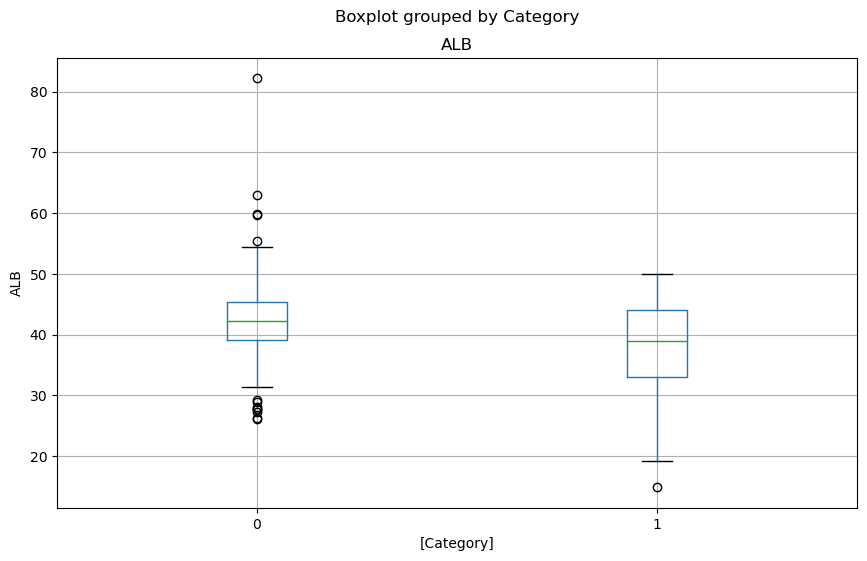

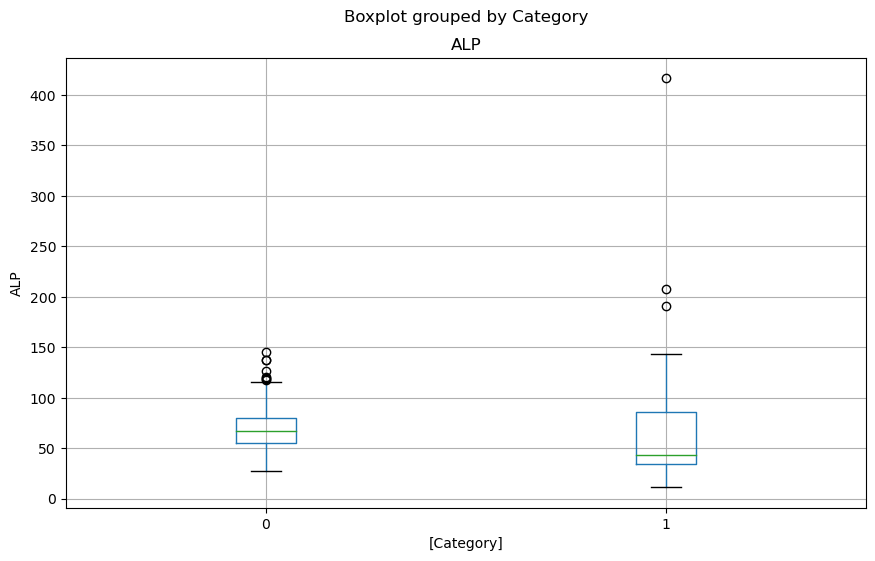

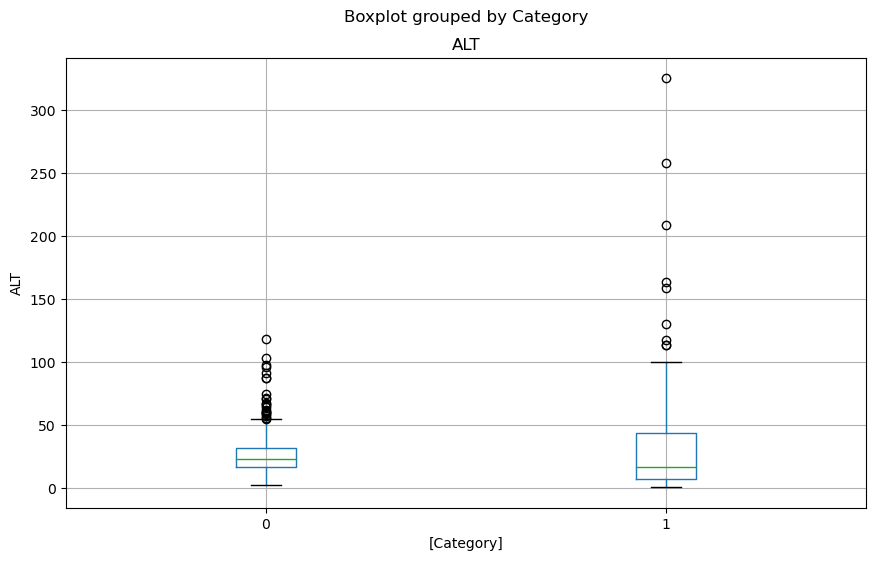

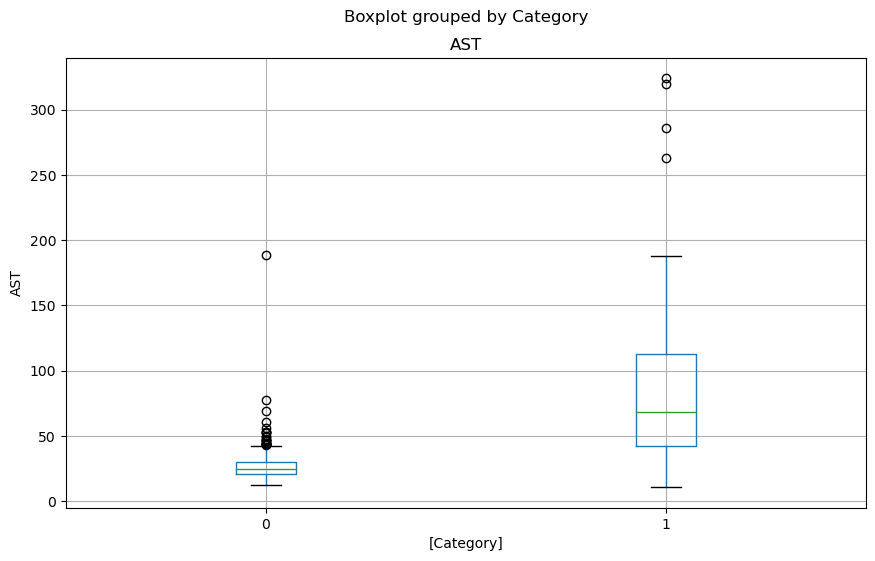

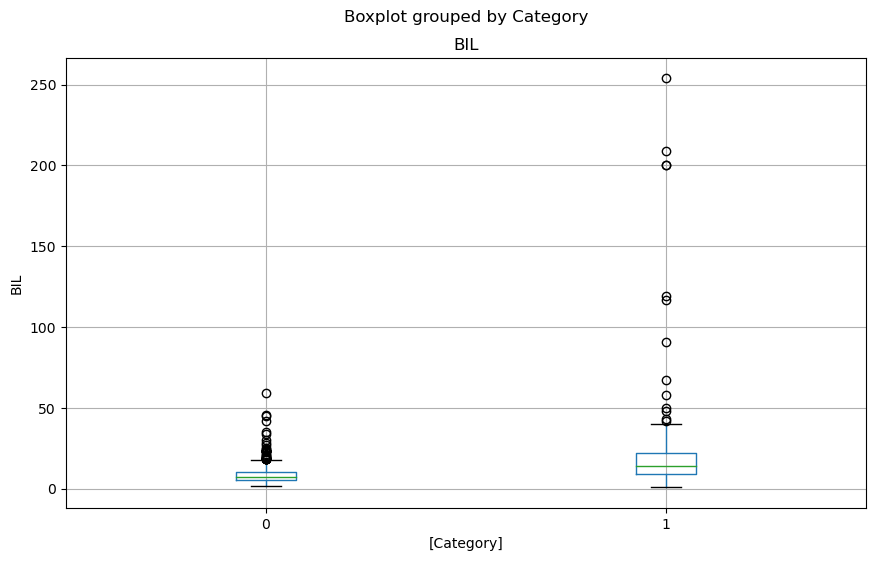

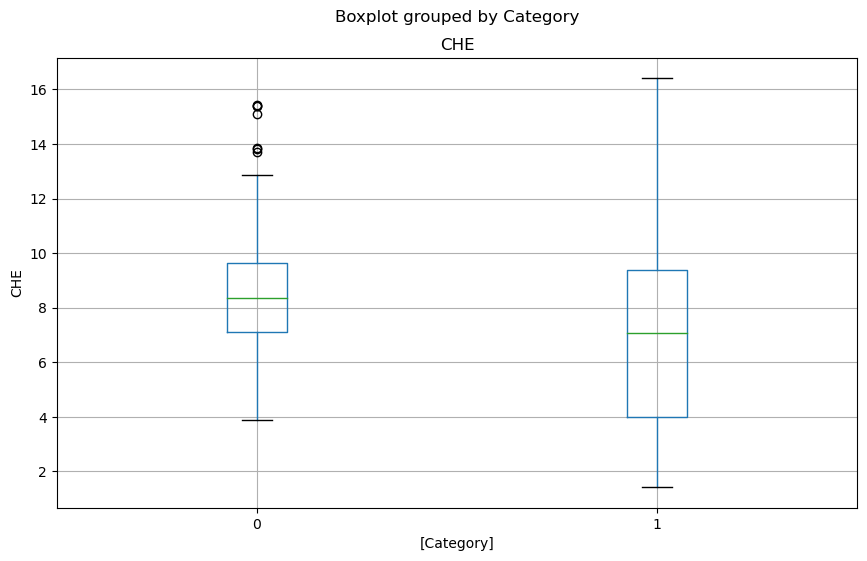

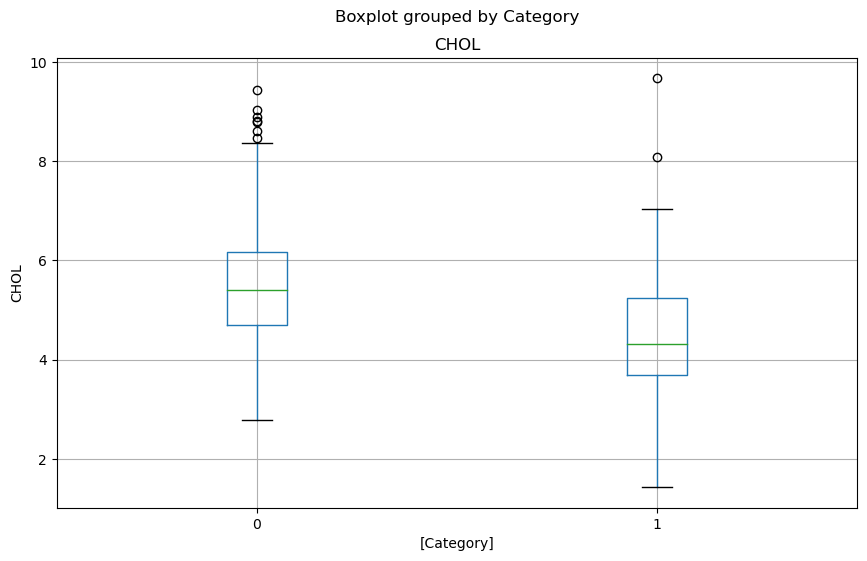

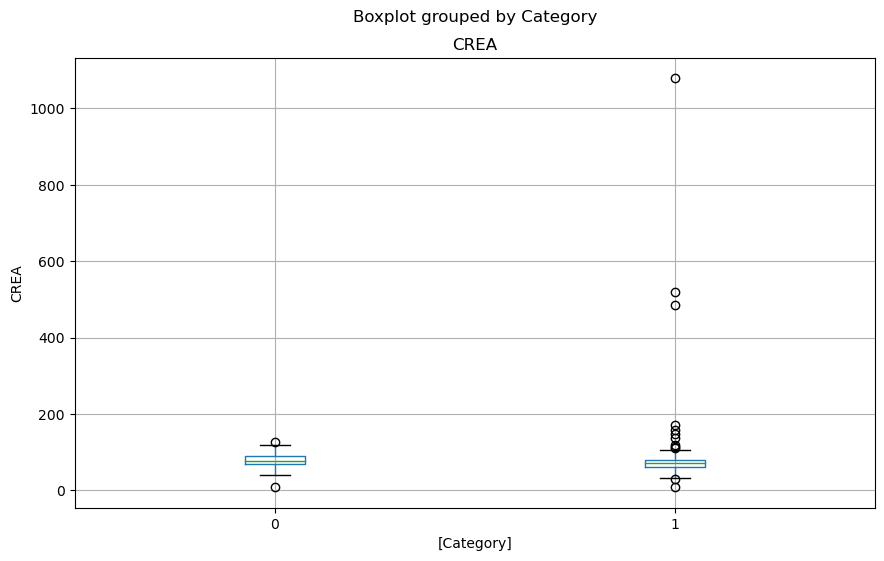

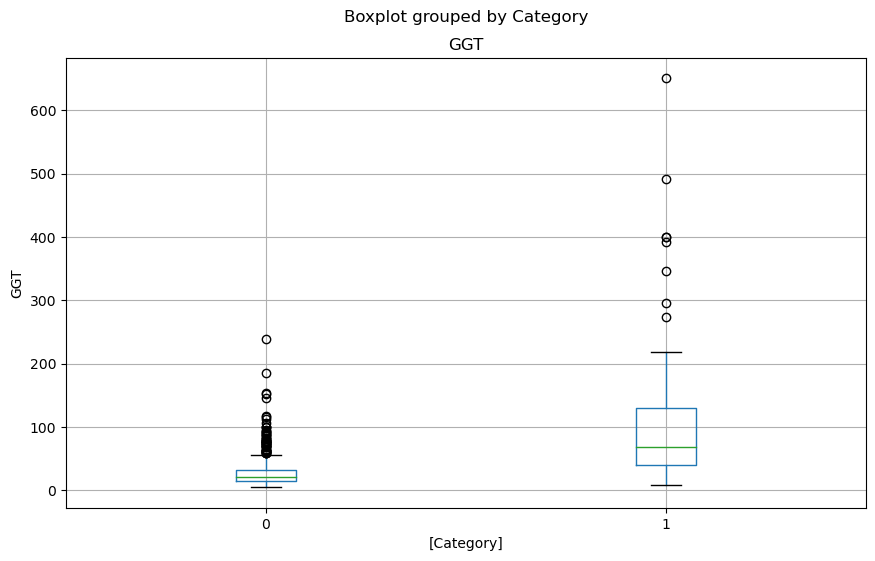

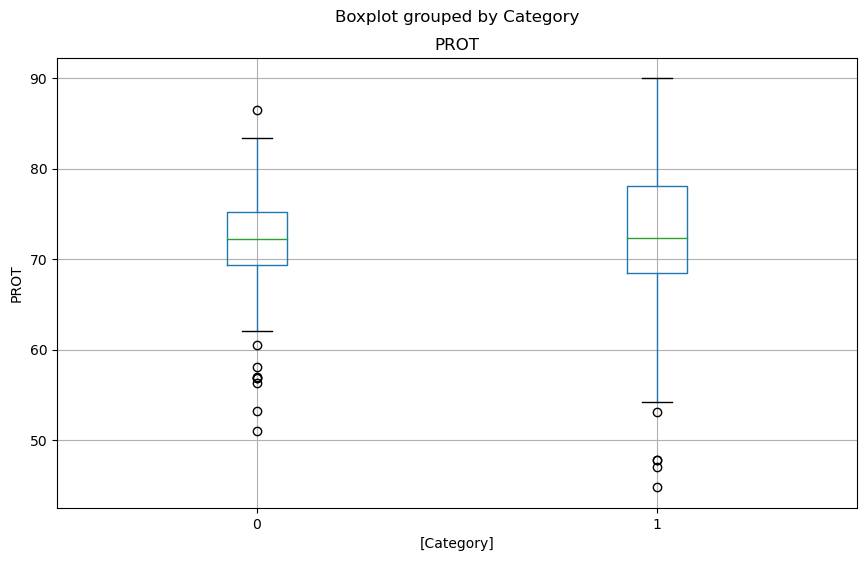

In [6]:
# Boxplots
df2[['Age','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('Age [Years]')
plt.show()
df2[['ALB','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('ALB')
plt.show()
df2[['ALP','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('ALP')
plt.show()
df2[['ALT','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('ALT')
plt.show()
df2[['AST','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('AST')
plt.show()
df2[['BIL','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('BIL')
plt.show()
df2[['CHE','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('CHE')
plt.show()
df2[['CHOL','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('CHOL')
plt.show()
df2[['CREA','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('CREA')
plt.show()
df2[['GGT','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('GGT')
plt.show()
df2[['PROT','Category']].boxplot(by='Category',figsize=(10,6))
plt.ylabel('PROT')
plt.show()

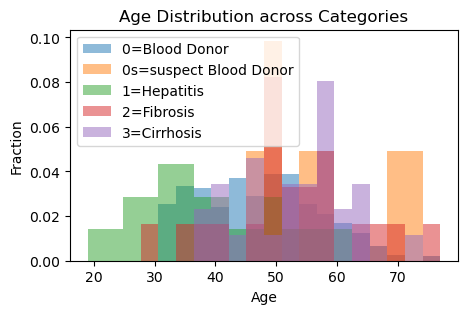

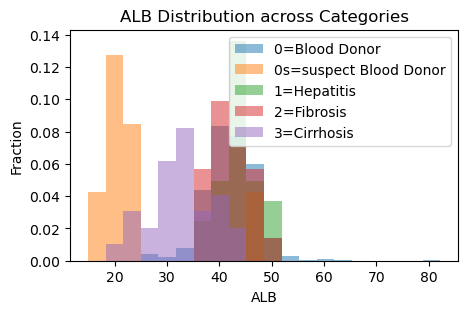

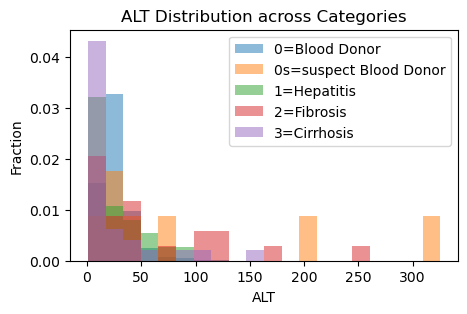

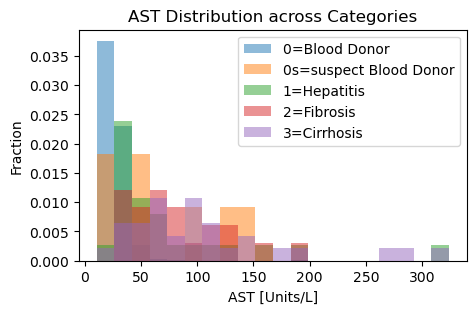

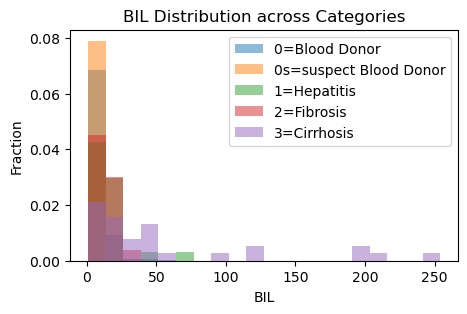

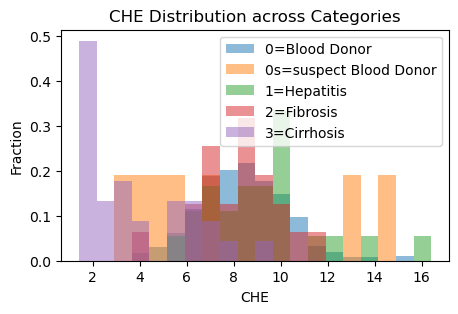

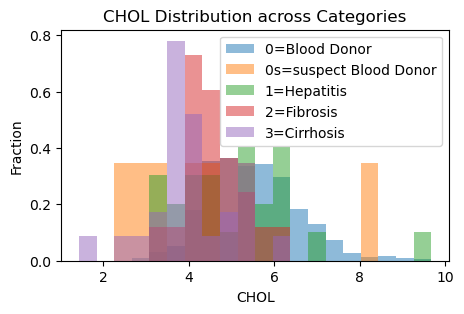

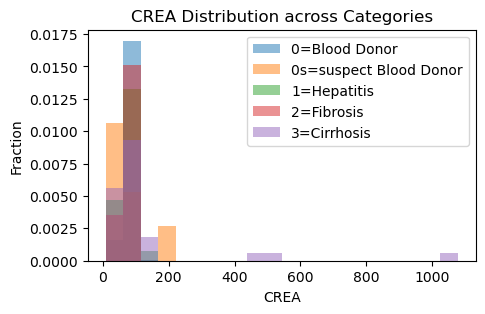

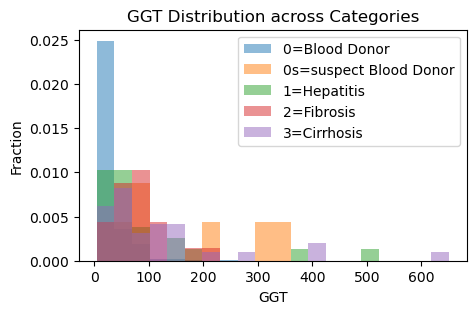

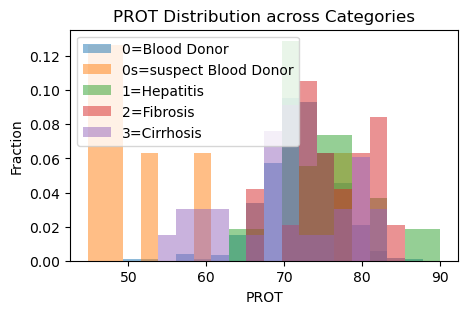

In [7]:
# Category Specific Histograms
categories = df['Category'].unique()
bin_range = (df['Age'].min(),df2['Age'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['Age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('Age')
plt.title('Age Distribution across Categories')
plt.show()
bin_range = (df['ALB'].min(),df['ALB'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['ALB'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('ALB')
plt.title('ALB Distribution across Categories')
plt.show()
bin_range = (df['ALT'].min(),df['ALT'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['ALT'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('ALT')
plt.title('ALT Distribution across Categories')
plt.show()
bin_range = (df['AST'].min(),df['AST'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['AST'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('AST [Units/L]')
plt.title('AST Distribution across Categories')
plt.show()
bin_range = (df['BIL'].min(),df['BIL'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['BIL'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('BIL')
plt.title('BIL Distribution across Categories')
plt.show()
bin_range = (df['CHE'].min(),df['CHE'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['CHE'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('CHE')
plt.title('CHE Distribution across Categories')
plt.show()
bin_range = (df['CHOL'].min(),df['CHOL'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['CHOL'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('CHOL')
plt.title('CHOL Distribution across Categories')
plt.show()
bin_range = (df['CREA'].min(),df['CREA'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['CREA'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('CREA')
plt.title('CREA Distribution across Categories')
plt.show()
bin_range = (df['GGT'].min(),df['GGT'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['GGT'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('GGT')
plt.title('GGT Distribution across Categories')
plt.show()
bin_range = (df['PROT'].min(),df['PROT'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[df['Category']==c]['PROT'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('PROT')
plt.title('PROT Distribution across Categories')
plt.show()

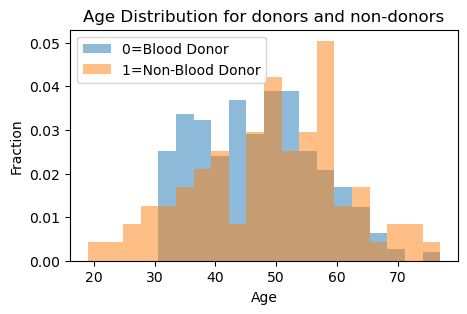

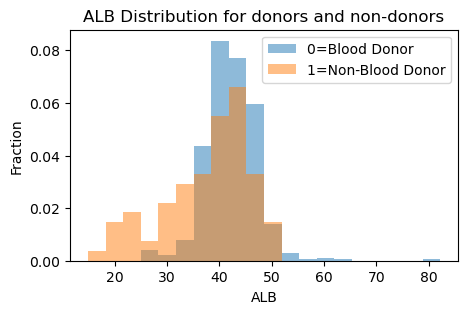

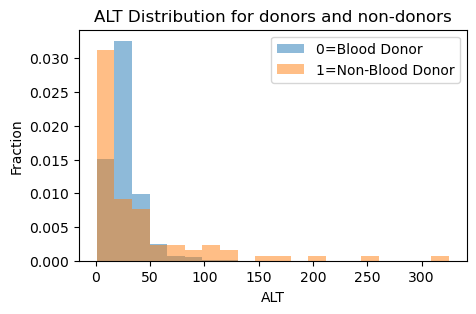

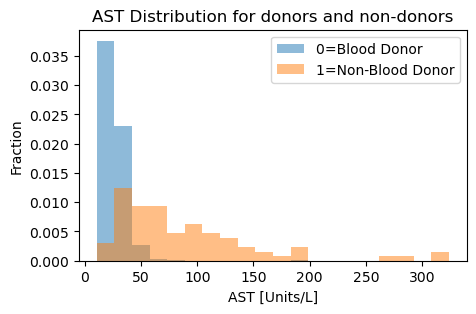

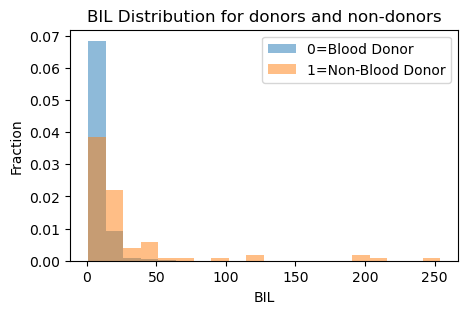

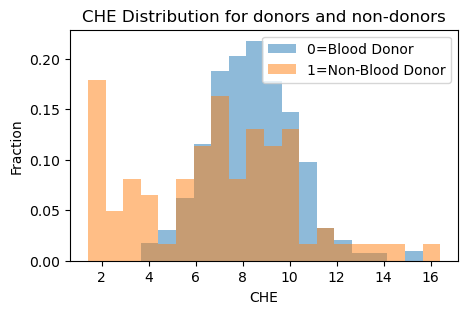

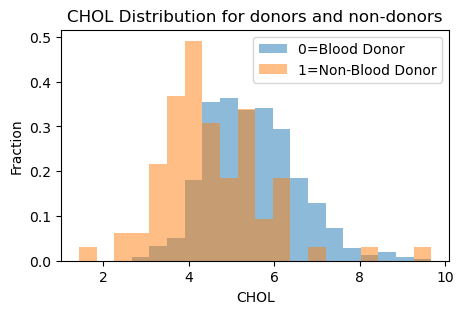

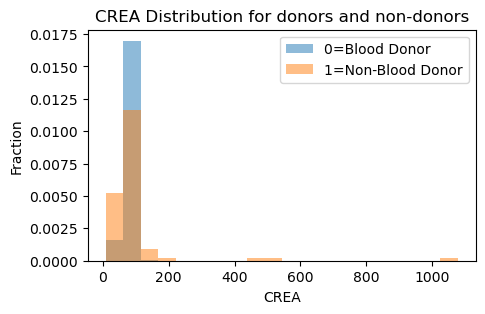

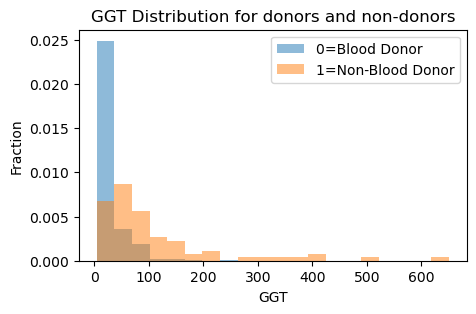

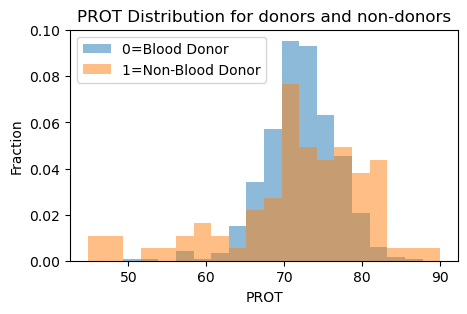

In [8]:
# Category Specific Histograms (Binary)
categories = df1['Category'].unique()
bin_range = (df1['Age'].min(),df1['Age'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['Age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('Age')
plt.title('Age Distribution for donors and non-donors')
plt.show()
bin_range = (df1['ALB'].min(),df1['ALB'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['ALB'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('ALB')
plt.title('ALB Distribution for donors and non-donors')
plt.show()
bin_range = (df1['ALT'].min(),df1['ALT'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['ALT'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('ALT')
plt.title('ALT Distribution for donors and non-donors')
plt.show()
bin_range = (df1['AST'].min(),df1['AST'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['AST'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('AST [Units/L]')
plt.title('AST Distribution for donors and non-donors')
plt.show()
bin_range = (df1['BIL'].min(),df1['BIL'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['BIL'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('BIL')
plt.title('BIL Distribution for donors and non-donors')
plt.show()
bin_range = (df1['CHE'].min(),df1['CHE'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['CHE'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('CHE')
plt.title('CHE Distribution for donors and non-donors')
plt.show()
bin_range = (df1['CHOL'].min(),df1['CHOL'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['CHOL'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('CHOL')
plt.title('CHOL Distribution for donors and non-donors')
plt.show()
bin_range = (df1['CREA'].min(),df1['CREA'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['CREA'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('CREA')
plt.title('CREA Distribution for donors and non-donors')
plt.show()
bin_range = (df1['GGT'].min(),df1['GGT'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['GGT'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('GGT')
plt.title('GGT Distribution for donors and non-donors')
plt.show()
bin_range = (df1['PROT'].min(),df1['PROT'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df1[df1['Category']==c]['PROT'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('PROT')
plt.title('PROT Distribution for donors and non-donors')
plt.show()

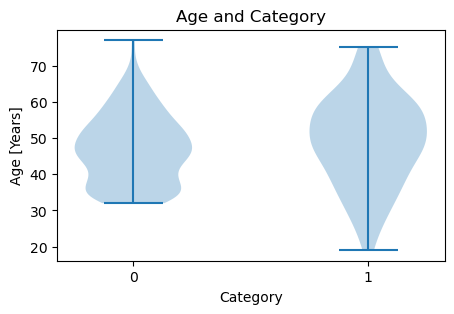

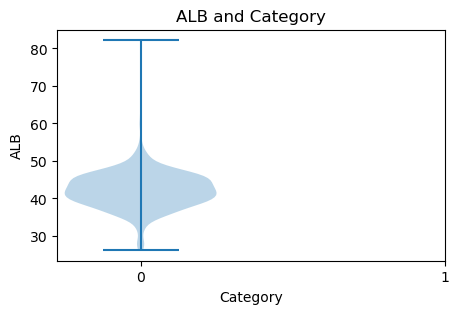

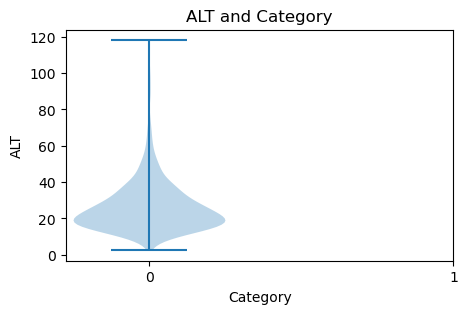

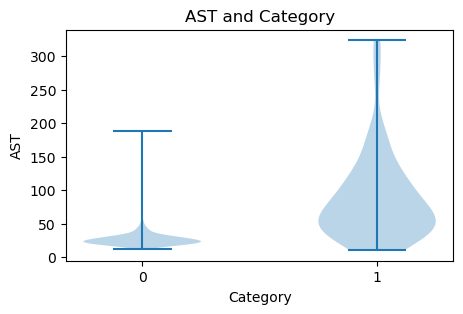

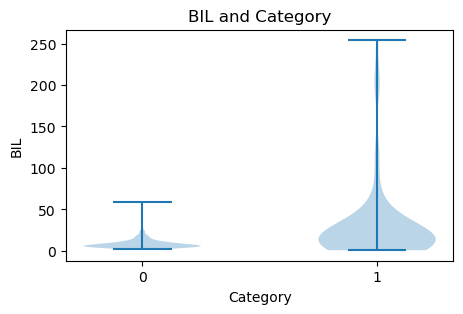

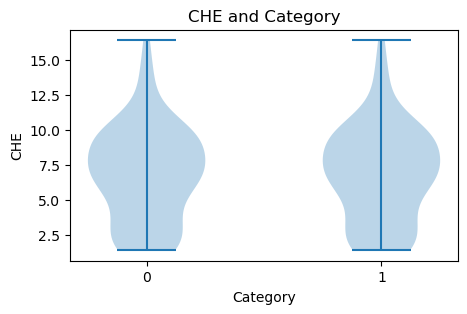

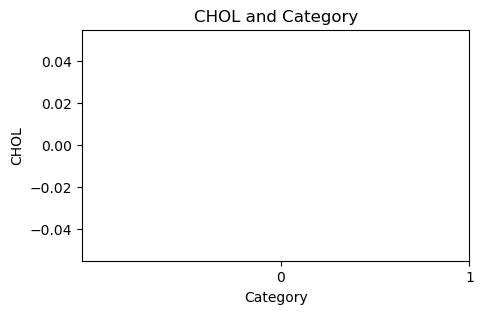

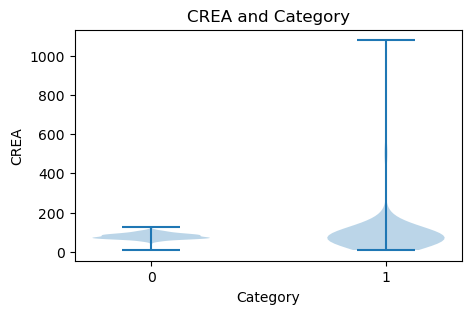

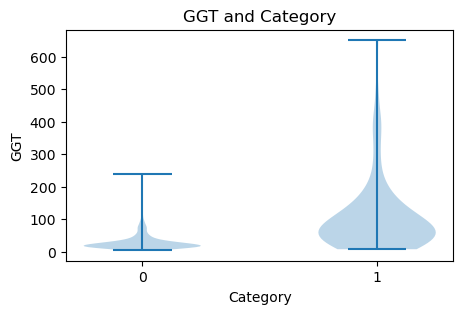

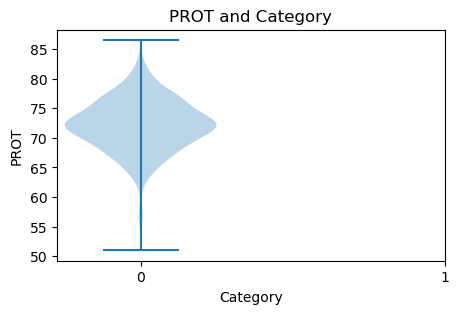

In [9]:
# Violin Plots
dataset = [df2[df2['Category']==0]['Age'].values,
           df2[df2['Category']==1]['Age'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('Age [Years]')
plt.xlabel('Category')
plt.title('Age and Category')
plt.show()
dataset = [df2[df2['Category']==0]['ALB'].values,
           df2[df2['Category']==1]['ALB'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('ALB')
plt.xlabel('Category')
plt.title('ALB and Category')
plt.show()
dataset = [df2[df2['Category']==0]['ALT'].values,
           df2[df2['Category']==1]['ALT'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('ALT')
plt.xlabel('Category')
plt.title('ALT and Category')
plt.show()
dataset = [df2[df2['Category']==0]['AST'].values,
           df2[df2['Category']==1]['AST'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('AST')
plt.xlabel('Category')
plt.title('AST and Category')
plt.show()
dataset = [df2[df2['Category']==0]['BIL'].values,
           df2[df2['Category']==1]['BIL'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('BIL')
plt.xlabel('Category')
plt.title('BIL and Category')
plt.show()
dataset = [df2[df2['Category']==1]['CHE'].values,
           df2[df2['Category']==1]['CHE'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('CHE')
plt.xlabel('Category')
plt.title('CHE and Category')
plt.show()
dataset = [df2[df2['Category']==0]['CHOL'].values,
           df2[df2['Category']==1]['CHOL'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('CHOL')
plt.xlabel('Category')
plt.title('CHOL and Category')
plt.show()
dataset = [df2[df2['Category']==0]['CREA'].values,
           df2[df2['Category']==1]['CREA'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('CREA')
plt.xlabel('Category')
plt.title('CREA and Category')
plt.show()
dataset = [df2[df2['Category']==0]['GGT'].values,
           df2[df2['Category']==1]['GGT'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('GGT')
plt.xlabel('Category')
plt.title('GGT and Category')
plt.show()
dataset = [df2[df2['Category']==0]['PROT'].values,
           df2[df2['Category']==1]['PROT'].values]
plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['0','1'])
plt.ylabel('PROT')
plt.xlabel('Category')
plt.title('PROT and Category')
plt.show()

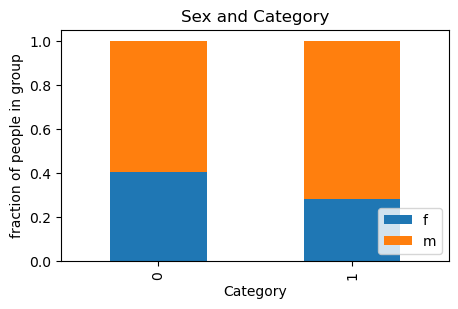

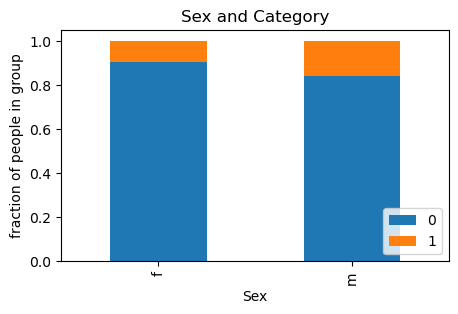

In [10]:
# Stacked Bar Plots
count_matrix = df2.groupby(['Category', 'Sex']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of people in group')
plt.title('Sex and Category')
plt.legend(loc=4)
plt.show()
count_matrix = df2.groupby(['Sex', 'Category']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of people in group')
plt.title('Sex and Category')
plt.legend(loc=4)
plt.show()

In [11]:
# Splitting the data
y = df2['Category']
X = df2.drop(columns=['Category'])
ftrs = df2.columns
random_state = 42
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)
X_CV, X_test, y_CV, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(369, 12)
(123, 12)
(123, 12)


In [12]:
# Pre-process the data
cat_ftrs = ['Sex']
num_ftrs = ['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT' ]

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

X_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_train.shape)
print(df_test.shape)
print(df_CV.shape)
print(feature_names)

(369, 13)
(123, 13)
(123, 13)
['num__Age' 'num__ALB' 'num__ALP' 'num__ALT' 'num__AST' 'num__BIL'
 'num__CHE' 'num__CHOL' 'num__CREA' 'num__GGT' 'num__PROT' 'cat__Sex_f'
 'cat__Sex_m']


In [13]:
# Missing values after pre-processing
print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (369, 13)
fraction of missing values in features:
num__ALP     0.02168
num__ALT     0.00271
num__CHOL    0.01626
dtype: float64
fraction of points with missing values: 0.037940379403794036


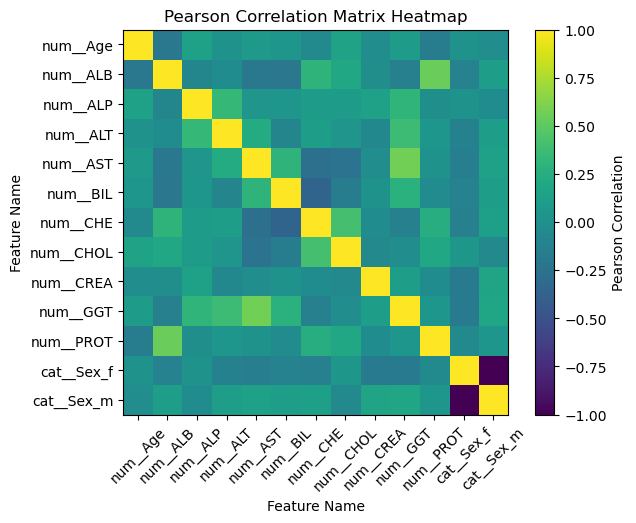

In [14]:
# Correlation matrix

correlation_matrix = df_train.corr(method='pearson')

plt.figure(figsize=(7, 5))
plt.imshow(correlation_matrix, vmin=-1, vmax=1)  
plt.colorbar(label='Pearson Correlation')
plt.xlabel('Feature Name')
plt.ylabel('Feature Name')
plt.title('Pearson Correlation Matrix Heatmap')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

In [25]:
def xgb_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    XGB = xgboost.XGBClassifier() 
    
    # find the best parameter set
    param_grid = {
                  "learning_rate": [0.03],
                  "n_estimators": [10000],
                  "seed": [0],
                  "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  "max_depth": [1,3,10,30,100],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]
    }

    pg = ParameterGrid(param_grid)

    scores = np.zeros(len(pg))

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        XGB.set_params(**params)
        eval_set = [(X_CV, y_CV)]
        XGB.fit(X_train, Y_train,
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)  # with early stopping
        y_CV_pred = XGB.predict(X_CV)
        scores[i] = f1_score(y_CV, y_CV_pred)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with the best parameter set
    XGB.set_params(**best_params[0])
    XGB.fit(X_train, Y_train,
            early_stopping_rounds=50, eval_set=eval_set, verbose=False)
    y_test_pred = XGB.predict(X_test)

    if verbose >= 1:
        print('The XGB F1 score is:', f1_score(y_test, y_test_pred))
    if verbose >= 2:
        print('The predictions are:')
        print(y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(XGB.feature_importances_)

    return f1_score(y_test, y_test_pred), y_test_pred, XGB.feature_importances_, XGB

In [16]:
# Function: Reduced-feature XGB model
def reduced_feature_xgb(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)):  # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]):  # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test, X_test.iloc[[j]]])  # append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])  # append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]

        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]

        # run XGB
        sub_y_test_pred = xgb_model(sub_X_train, sub_Y_train, sub_X_CV,
                                     sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1], columns=['sub_y_test_pred'],
                                       index=sub_y_test.index)
        print('   F1 Score:', f1_score(sub_y_test, sub_y_test_pred))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

    # rank the final y_test_pred according to the original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()

    # get global F1 Score
    total_F1 = f1_score(y_test, all_y_test_pred)
    return total_F1

In [17]:
# Function: Reduced-feature Logistic Regression model
def logistic_regression_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):
    # choose a parameter grid for hyperparameter tuning
    param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
                  'C': [0.001, 0.01, 0.1, 1, 10],
                  'l1_ratio': [0.1, 0.5, 0.9]}

    train_score = np.zeros(len(ParameterGrid(param_grid)))
    CV_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    test_scores = np.zeros(len(ParameterGrid(param_grid)))
    final_models = []
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = LogisticRegression(solver='saga', max_iter=1000) # initialize the classifier
        clf.fit(X_train,Y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train)
        train_score[p] = f1_score(Y_train,y_train_pred)
        y_CV_pred = clf.predict(X_CV)
        CV_score[p] = f1_score(y_CV,y_CV_pred)
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(CV_score)])
    print('corresponding validation score:',np.max(CV_score))
    # collect and save the best model
    final_models.append(models[np.argmax(CV_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test)
    test_score = f1_score(y_test,y_test_pred)
    print('test score:',test_score)

    return test_score, y_test_pred

# Function: Reduced-feature Logistic Regression model
# all the inputs need to be pandas DataFrame
def reduced_feature_logistic_regression(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    # find all unique patterns of missing value in the test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)):  # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]):  # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test, X_test.iloc[[j]]])  # append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])  # append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]

        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]

        # run Logistic regression
        sub_y_test_pred = logistic_regression_model(sub_X_train, sub_Y_train, sub_X_CV,
                                     sub_y_CV, sub_X_test, sub_y_test, verbose=1)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1], columns=['sub_y_test_pred'],
                                       index=sub_y_test.index)
        print('   F1 Score:', f1_score(sub_y_test, sub_y_test_pred))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

    # rank the final y_test_pred according to the original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()

    # get global F1 Score
    total_F1 = f1_score(y_test, all_y_test_pred)
    return total_F1

In [18]:
# Function: Reduced-feature Random Forest model
def random_forest_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):
    # choose a parameter grid for hyperparameter tuning
    param_grid = {'n_estimators': [3, 5, 7, 10, 50],
                  'max_depth': [1, 3, 5, 10, 20]}
    
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    CV_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    test_scores = np.zeros(len(ParameterGrid(param_grid)))
    final_models = []
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = RandomForestClassifier() # initialize the classifier
        clf.fit(X_train,Y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train)
        train_score[p] = f1_score(Y_train,y_train_pred)
        y_CV_pred = clf.predict(X_CV)
        CV_score[p] = f1_score(y_CV,y_CV_pred)
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(CV_score)])
    print('corresponding validation score:',np.max(CV_score))
    # collect and save the best model
    final_models.append(models[np.argmax(CV_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test)
    test_score = f1_score(y_test,y_test_pred)
    print('test score:',test_score)

    return test_score, y_test_pred

def reduced_feature_random_forest(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    # find all unique patterns of missing value in the test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)):  # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]):  # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test, X_test.iloc[[j]]])  # append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])  # append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]

        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]

        # run Random Forrest
        sub_y_test_pred = random_forest_model(sub_X_train, sub_Y_train, sub_X_CV,
                                     sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1], columns=['sub_y_test_pred'],
                                       index=sub_y_test.index)
        print('   F1 Score:', f1_score(sub_y_test, sub_y_test_pred))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

    # rank the final y_test_pred according to the original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()

    # get global F1 Score
    total_F1 = f1_score(y_test, all_y_test_pred)
    return total_F1

In [19]:
# Function: Reduced-feature SVC model
def svc_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):
    # choose a parameter grid for hyperparameter tuning
    param_grid = {'C': [0.1, 1, 10],
                  'kernel': ['linear', 'rbf', 'poly'],
                  'gamma': np.logspace(-1,2,5)}
    
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    CV_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    test_scores = np.zeros(len(ParameterGrid(param_grid)))
    final_models = []
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = SVC() # initialize the classifier
        clf.fit(X_train,Y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train)
        train_score[p] = f1_score(Y_train,y_train_pred)
        y_CV_pred = clf.predict(X_CV)
        CV_score[p] = f1_score(y_CV,y_CV_pred)
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(CV_score)])
    print('corresponding validation score:',np.max(CV_score))
    # collect and save the best model
    final_models.append(models[np.argmax(CV_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test)
    test_score = f1_score(y_test,y_test_pred)
    print('test score:',test_score)

    return test_score, y_test_pred

# Function: Reduced-feature Support Vector Classifier (SVC)
# all the inputs need to be pandas DataFrame
def reduced_feature_svc(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    # find all unique patterns of missing value in the test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)):  # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]):  # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test, X_test.iloc[[j]]])  # append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])  # append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]

        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]

        # run SVC
        sub_y_test_pred = svc_model(sub_X_train, sub_Y_train, sub_X_CV,
                                     sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1], columns=['sub_y_test_pred'],
                                       index=sub_y_test.index)
        print('   F1 Score:', f1_score(sub_y_test, sub_y_test_pred))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

    # rank the final y_test_pred according to the original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()

    # get global F1 Score
    total_F1 = f1_score(y_test, all_y_test_pred)
    return total_F1

In [20]:
# Function: Reduced-feature KNN model
def knn_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):
    # choose a parameter grid for hyperparameter tuning
    param_grid = {'n_neighbors': [1,2,3,5,10,30,100],
                  'weights': ['uniform', 'distance']}
    
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    CV_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    test_scores = np.zeros(len(ParameterGrid(param_grid)))
    final_models = []
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = KNeighborsClassifier() # initialize the classifier
        clf.fit(X_train,Y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train)
        train_score[p] = f1_score(Y_train,y_train_pred)
        y_CV_pred = clf.predict(X_CV)
        CV_score[p] = f1_score(y_CV,y_CV_pred)
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(CV_score)])
    print('corresponding validation score:',np.max(CV_score))
    # collect and save the best model
    final_models.append(models[np.argmax(CV_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test)
    test_score = f1_score(y_test,y_test_pred)
    print('test score:',test_score)

    return test_score, y_test_pred

# Function: Reduced-feature K-Nearest Neighbors (KNN) model
# all the inputs need to be pandas DataFrame
def reduced_feature_knn(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    # find all unique patterns of missing value in the test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)):  # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]):  # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test, X_test.iloc[[j]]])  # append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])  # append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]

        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]

        # run KNN
        sub_y_test_pred = knn_model(sub_X_train, sub_Y_train, sub_X_CV,
                                     sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1], columns=['sub_y_test_pred'],
                                       index=sub_y_test.index)
        print('   F1 Score:', f1_score(sub_y_test, sub_y_test_pred))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

    # rank the final y_test_pred according to the original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()

    # get global F1 Score
    total_F1 = f1_score(y_test, all_y_test_pred)
    return total_F1

In [88]:
# Looping through 5 random states
random_states = [999, 123, 456, 789, 42]
F1=[]
F1xgb=[]
F1logreg=[]
F1randomf=[]
F1svc=[]
F1knn=[]
baselineF1=[]
for random_state in random_states:
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)
    X_CV, X_test, y_CV, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)
    X_prep = preprocessor.fit_transform(X_train)
    feature_names = preprocessor.get_feature_names_out()
    df_train = pd.DataFrame(data=X_prep,columns=feature_names)
    df_CV = preprocessor.transform(X_CV)
    df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
    df_test = preprocessor.transform(X_test)
    df_test = pd.DataFrame(data=df_test,columns = feature_names)
    F1score, y_test_pred, feature_importances, model = xgb_model(df_train, y_train, df_CV, y_CV, df_test, y_test, verbose=4)
    F1xgbscore = reduced_feature_xgb(df_train, y_train, df_CV, y_CV, df_test, y_test)
    F1logregscore = reduced_feature_logistic_regression(df_train, y_train, df_CV, y_CV, df_test, y_test)
    F1randomfscore = reduced_feature_random_forest(df_train, y_train, df_CV, y_CV, df_test, y_test)
    F1svcscore = reduced_feature_svc(df_train, y_train, df_CV, y_CV, df_test, y_test)
    F1knnscore = reduced_feature_knn(df_train, y_train, df_CV, y_CV, df_test, y_test)
    class_distribution = np.bincount(y_test)
    minority_class = np.argmin(class_distribution)
    baseline_predictions = np.full_like(y_test, fill_value=minority_class)
    baseline_f1score = f1_score(y_test, baseline_predictions)
    F1.append(F1score)
    F1xgb.append(F1xgbscore)
    F1logreg.append(F1logregscore)
    F1randomf.append(F1randomfscore)
    F1svc.append(F1svcscore)
    F1knn.append(F1knnscore)
    baselineF1.append(baseline_f1score)
    
print('Mean Baseline F1:', np.mean(baselineF1), 'Standard Deviation:', np.std(baselineF1))
print('Mean XGB Test F1:', np.mean(F1), 'Standard Deviation:', np.std(F1))
print('Mean Reduced Features XGB Test F1:', np.mean(F1xgb), 'Standard Deviation:', np.std(F1xgb))
print('Mean Reduced Features Logistic Regression Test F1:', np.mean(F1logreg), 'Standard Deviation:', np.std(F1logreg))
print('Mean Reduced Features Random Forest Test F1:', np.mean(F1randomf), 'Standard Deviation:', np.std(F1randomf))
print('Mean Reduced Features SVC Test F1:', np.mean(F1svc), 'Standard Deviation:', np.std(F1svc))
print('Mean Reduced Features KNN Test F1:', np.mean(F1knn), 'Standard Deviation:', np.std(F1knn))

Test set max score and best parameters are:
0.9032258064516129
[{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'seed': 0, 'subsample': 0.66}
 {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'reg_alpha': 0.0, 'reg_lambda': 0.01, 'seed': 0, 'subsample': 0.66}
 {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'reg_alpha': 0.0, 'reg_lambda': 0.1, 'seed': 0, 'subsample': 0.66}
 {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'seed': 0, 'subsample': 0.66}
 {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'reg_alpha': 0.01, 'reg_lambda': 0.0, 'seed': 0, 'subsample': 0.66}
 {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'missing'

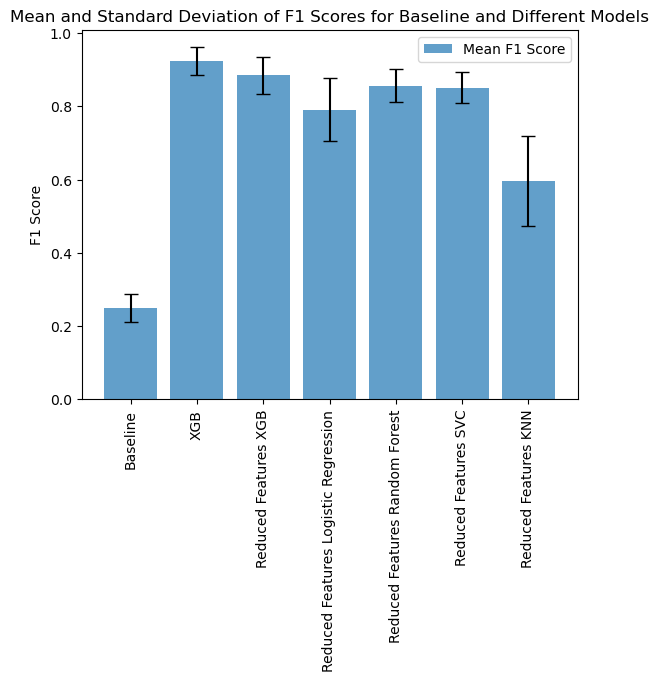

In [89]:
# plotting F1 scores
models = ['Baseline', 'XGB', 'Reduced Features XGB', 'Reduced Features Logistic Regression', 'Reduced Features Random Forest', 'Reduced Features SVC', 'Reduced Features KNN']
mean_scores = [np.mean(baselineF1), np.mean(F1), np.mean(F1xgb), np.mean(F1logreg), np.mean(F1randomf), np.mean(F1svc), np.mean(F1knn)]
std_devs = [np.std(baselineF1), np.std(F1), np.std(F1xgb), np.std(F1logreg), np.std(F1randomf), np.std(F1svc), np.std(F1knn)]
bars = plt.bar(models, mean_scores, yerr=std_devs, capsize=5, alpha=0.7, label='Mean F1 Score')
plt.xticks(rotation=90, ha='center')
plt.ylabel('F1 Score')
plt.title('Mean and Standard Deviation of F1 Scores for Baseline and Different Models')
plt.legend()
plt.show()

Param set 1 / 180
Param set 2 / 180
Param set 3 / 180
Param set 4 / 180
Param set 5 / 180
Param set 6 / 180
Param set 7 / 180
Param set 8 / 180
Param set 9 / 180
Param set 10 / 180
Param set 11 / 180
Param set 12 / 180
Param set 13 / 180
Param set 14 / 180
Param set 15 / 180
Param set 16 / 180
Param set 17 / 180
Param set 18 / 180
Param set 19 / 180
Param set 20 / 180
Param set 21 / 180
Param set 22 / 180
Param set 23 / 180
Param set 24 / 180
Param set 25 / 180
Param set 26 / 180
Param set 27 / 180
Param set 28 / 180
Param set 29 / 180
Param set 30 / 180
Param set 31 / 180
Param set 32 / 180
Param set 33 / 180
Param set 34 / 180
Param set 35 / 180
Param set 36 / 180
Param set 37 / 180
Param set 38 / 180
Param set 39 / 180
Param set 40 / 180
Param set 41 / 180
Param set 42 / 180
Param set 43 / 180
Param set 44 / 180
Param set 45 / 180
Param set 46 / 180
Param set 47 / 180
Param set 48 / 180
Param set 49 / 180
Param set 50 / 180
Param set 51 / 180
Param set 52 / 180
Param set 53 / 180
Pa

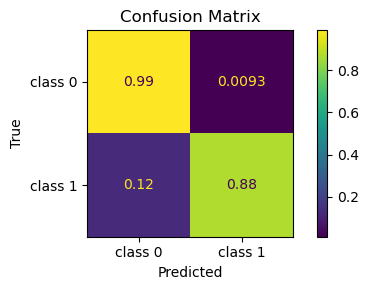

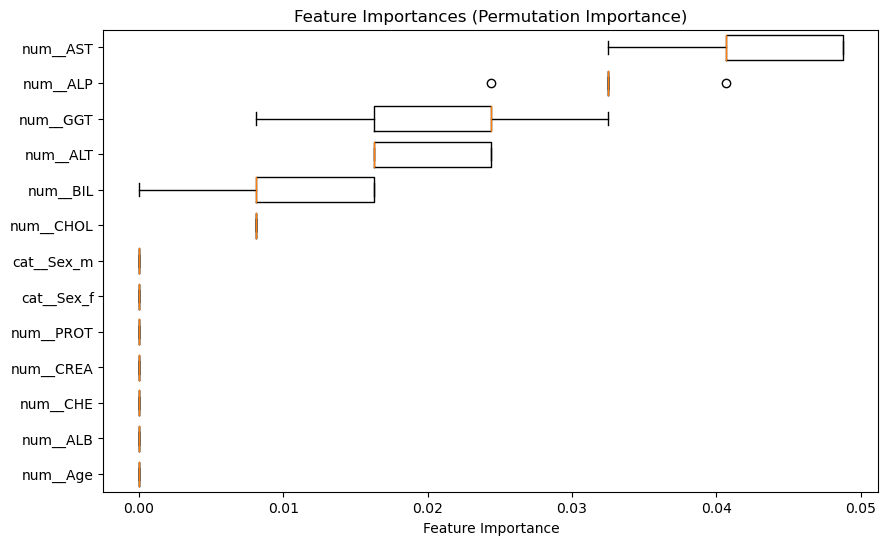

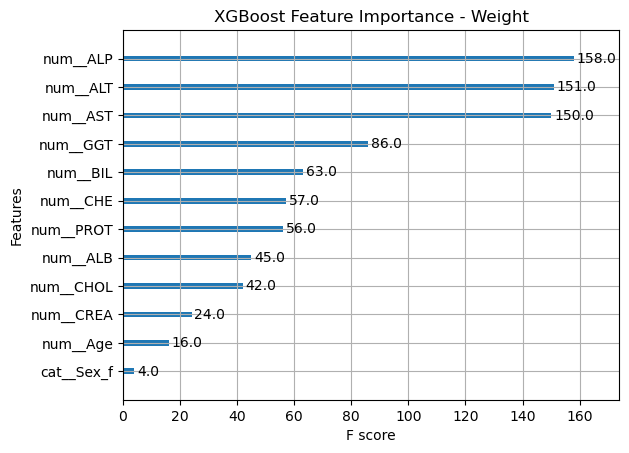

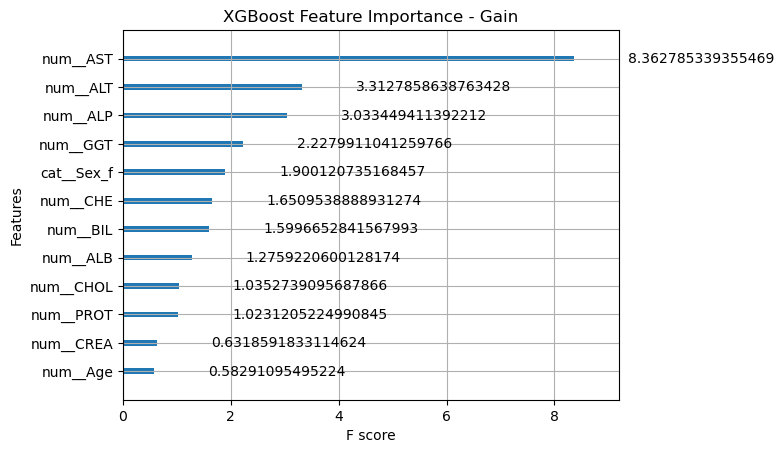

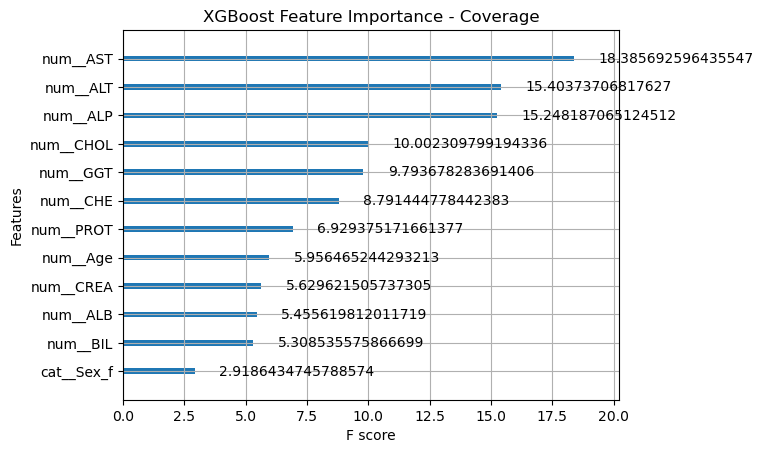

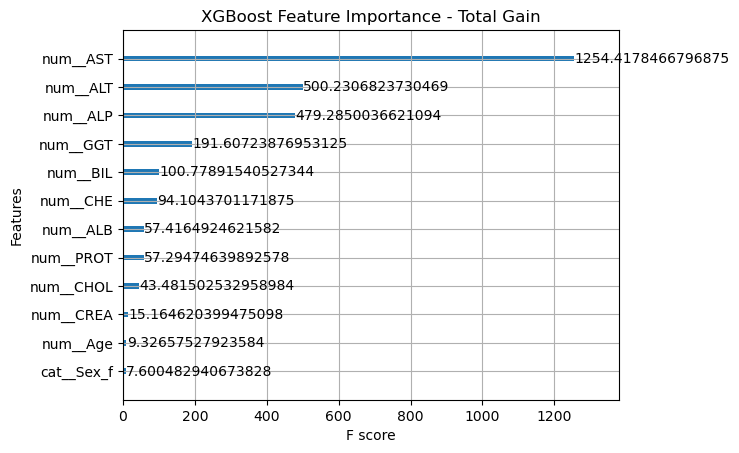

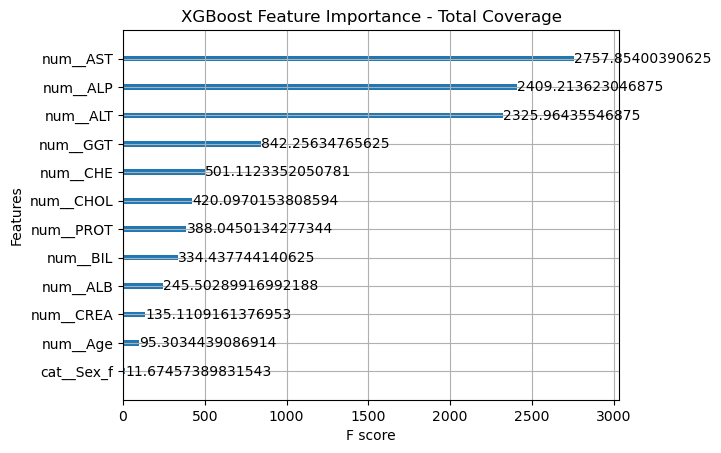

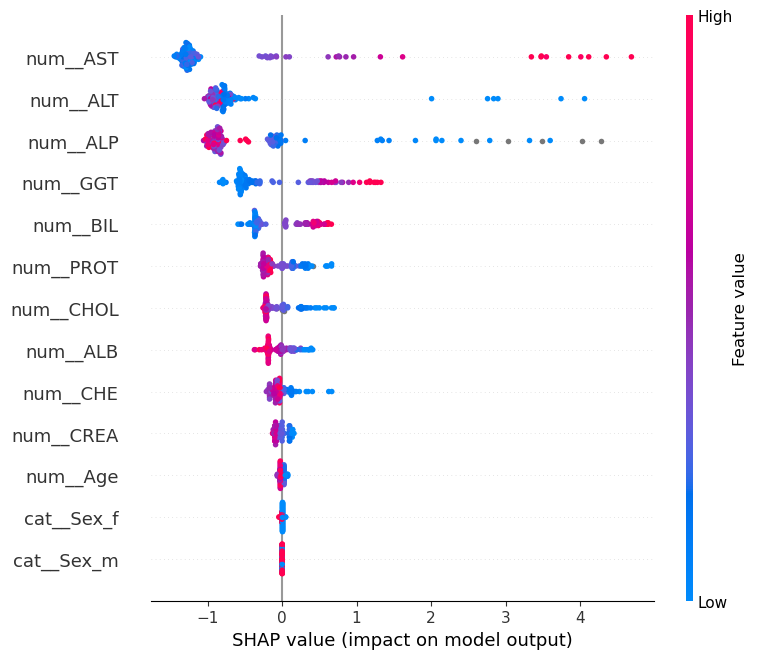

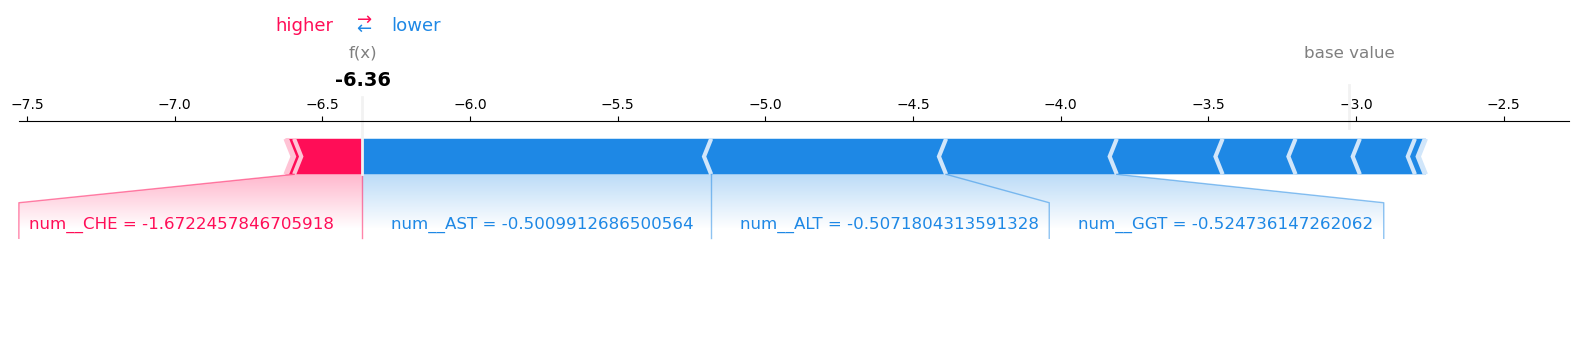

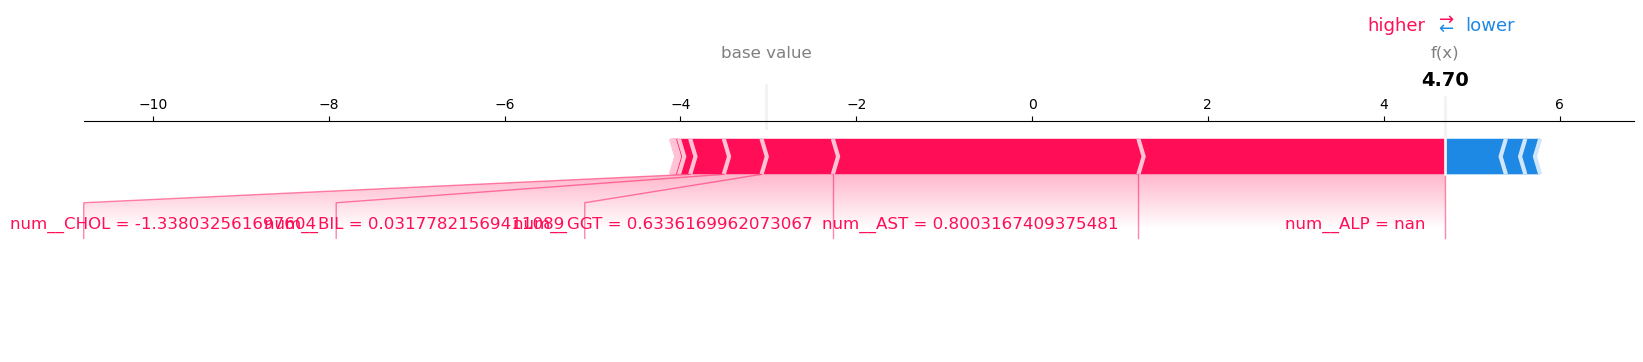

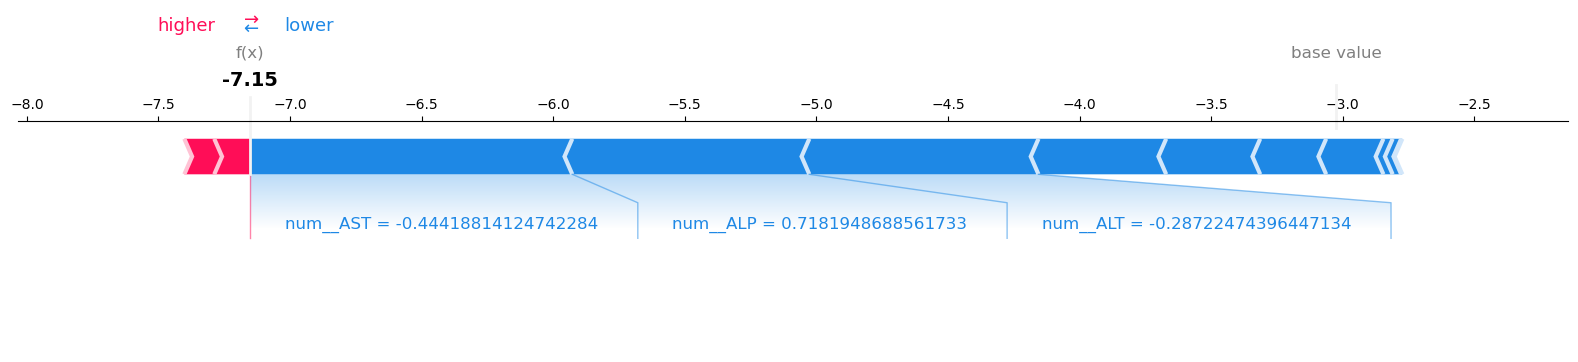

In [26]:
# Interpretability
f1, y_test_pred, feature_importances, model = xgb_model(df_train, y_train, df_CV, y_CV, df_test, y_test, verbose=5)

cm = confusion_matrix(y_test, y_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(5,3))
disp.plot(ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

result = permutation_importance(model, df_test, y_test)
top_indices = np.argsort(result.importances_mean)
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[top_indices].T, vert=False, labels=feature_names[top_indices], widths=0.7)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Permutation Importance)')
plt.show()

plot_importance(model, importance_type='weight', title='XGBoost Feature Importance - Weight')
plt.show()
plot_importance(model, importance_type='gain', title='XGBoost Feature Importance - Gain')
plt.show()
plot_importance(model, importance_type='cover', title='XGBoost Feature Importance - Coverage')
plt.show()
plot_importance(model, importance_type='total_gain', title='XGBoost Feature Importance - Total Gain')
plt.show()
plot_importance(model, importance_type='total_cover', title='XGBoost Feature Importance - Total Coverage')
plt.show()

shap.initjs() 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test)
shap.summary_plot(shap_values, df_test,feature_names = feature_names)

indices = [0, 5, 10]
for id in indices:
    shap.force_plot(explainer.expected_value, shap_values[id, :], features=df_test.iloc[id, :], feature_names=feature_names, matplotlib=True)
    

model_filename = 'best_model.joblib'

joblib.dump(model, model_filename)

# Save the predictions
predictions_df = pd.DataFrame({
    'True_Labels': y_test,   
    'Predicted_Labels': y_test_pred
})
predictions_filename = 'predictions.csv'
predictions_df.to_csv(predictions_filename, index=False)